In [92]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from plot_utils import cblind_cmap

plt.style.use("style.mplstyle")

PHASES = ["liquid", "ice", "mixed", "drizzle", "liq_driz", "rain", "snow"]
letter_labels = [f"({letter})" for letter in "abcdefghijklmnopqrstuvwxyz"]

cmap = cblind_cmap.copy()
cmap["avg"] = "black"

phases = [
    "liquid", 
    "ice", 
    "mixed", 
    "drizzle", 
    "liq_driz", 
    "rain", 
    "snow",
]
models = {
    "cnn": "CNN",
    "mlp": "MLP",
    "rf": "RF",
    # "avg": "Avg"
}

In [42]:
FEATURE_NAME_MAP = {
    "mpl_backscatter": r"MPL $\beta$",
    "mpl_linear_depol_ratio": "MPL Dep",
    "reflectivity": "$Z_e$ (dBZ)",
    "mean_doppler_velocity": "MDV (m/s)",
    "spectral_width": "W (m/s)",
    "radar_linear_depolarization_ratio": "Radar Dep",
    "mwrret1liljclou_be_lwp": "LWP (g/$m^2$)",
    "temp": r"T ($\degree C$)",
}


def load_importances() -> tuple[pd.DataFrame, pd.DataFrame]:
    """Loads phase importance files for each model and returns a new dataframe with
    columns: "feature", "acc", "importance", "model". Also does this for the
    phase-height files. Returns the combined phase importance dataframe and the combined
    phase-height importance dataframe."""
    data_path = Path("data/importance/")
    _models = ["cnn", "mlp", "rf"]

    _p_i_dfs = []
    for _model in _models:
        df = pd.read_parquet(data_path / f"{_model}_phase_importances.parquet")
        df["model"] = _model
        df["feature"] = pd.Categorical(
            df["feature"].map(FEATURE_NAME_MAP),
            categories=FEATURE_NAME_MAP.values(),
            ordered=True,
        )
        df = df.sort_values("feature").rename(columns={"acc": "recall"})
        _p_i_dfs.append(df)
    p_i_df = pd.concat(_p_i_dfs)

    _p_h_i_dfs = []
    for _model in _models:
        df = pd.read_parquet(data_path / f"{_model}_phase_height_importance.parquet")
        df["model"] = _model
        df = df.rename(columns={"acc": "recall", "variable": "feature"})
        df["feature"] = pd.Categorical(
            df["feature"].map(FEATURE_NAME_MAP),
            categories=FEATURE_NAME_MAP.values(),
            ordered=True,
        )
        df = df.sort_values("feature")
        _p_h_i_dfs.append(df)
    p_h_i_df = pd.concat(_p_h_i_dfs)
    return p_i_df.reset_index(), p_h_i_df.reset_index()

imp_df, height_imp_df = load_importances()

# Add an "avg" model, which is the mean importance of the other models
# _p_i_phase_feature_df = (
#     imp_df
#     .groupby(["phase", "feature"])
#     .agg(
#         importance=pd.NamedAgg("importance", "mean"),
#         recall=pd.NamedAgg("recall", "mean"),
#     )
#     .reset_index()
# )
# _p_i_phase_feature_df["model"] = "avg"
# imp_df = pd.concat([imp_df, _p_i_phase_feature_df])

imp_df

,phase,feature,recall,importance,model
0,drizzle,MPL $\beta$,0.817460,0.008082,cnn
1,avg,MPL $\beta$,0.817330,0.077764,cnn
2,snow,MPL $\beta$,0.935376,0.001934,cnn
3,liquid,MPL $\beta$,0.609254,0.272351,cnn
4,ice,MPL $\beta$,0.966042,0.018538,cnn
...,...,...,...,...,...
187,liq_driz,T ($\degree C$),0.050343,0.862723,rf
188,drizzle,T ($\degree C$),0.041909,0.854176,rf
189,mixed,T ($\degree C$),0.759736,0.124508,rf
190,ice,T ($\degree C$),0.804658,0.046938,rf


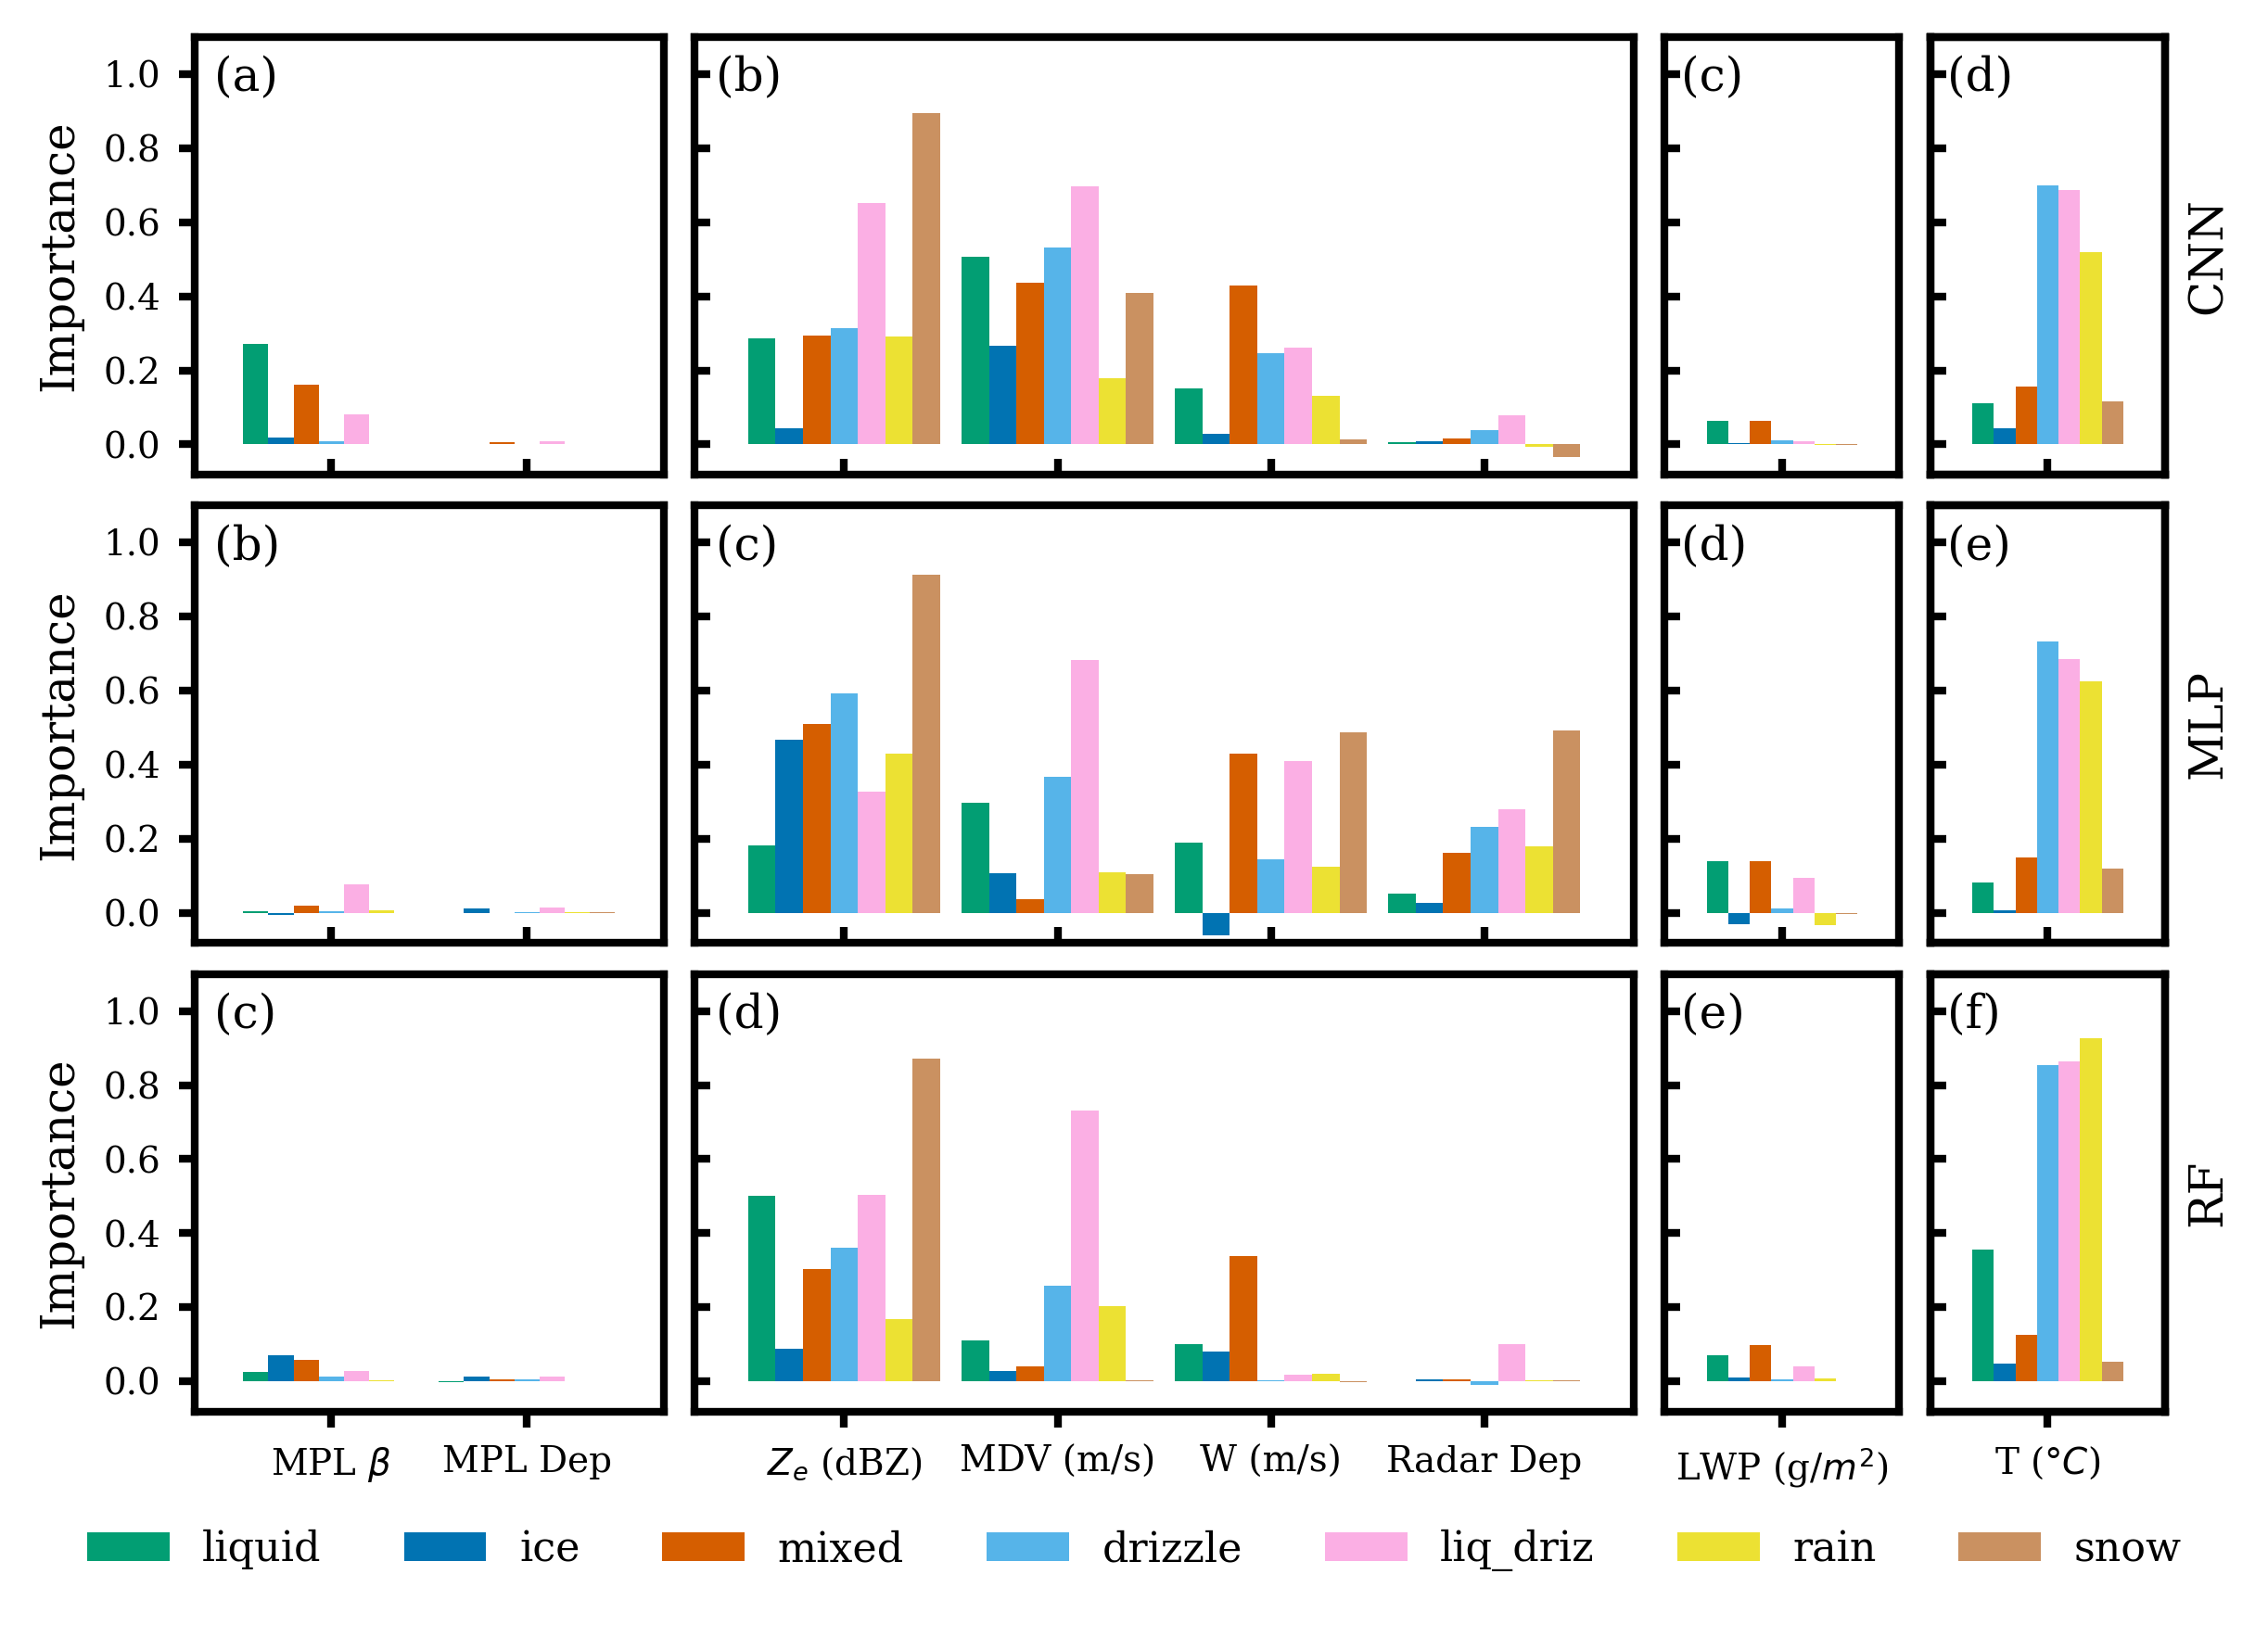

In [98]:
min_importance = min(-0.05, imp_df["importance"].min() - 0.02)

groups = {
    "MPL": [r"MPL $\beta$", "MPL Dep"],
    "Radar": ["$Z_e$ (dBZ)", "MDV (m/s)", "W (m/s)", "Radar Dep"],
    "LWP": ["LWP (g/$m^2$)"],
    "T": [r"T ($\degree C$)"],
}

fig, axs = plt.subplots(
    figsize=(6, 4),
    nrows=len(models),
    ncols=len(groups),
    # sharex=True,
    sharey=True,
    gridspec_kw={"width_ratios": [len(g) for g in groups.values()]},
    layout="constrained",
)

for i, (model, model_label) in enumerate(models.items()):
    # reshape importances to have index of feature and phase importances as columns. we
    # don't need 'avg' importance for this plot
    _model_data = imp_df[(imp_df["model"] == model) & (imp_df["phase"] != "avg")]
    data = _model_data.pivot(index="feature", columns="phase", values="importance")
    data = data[phases]  # sort cols

    for j, (group_title, group_vars) in enumerate(groups.items()):
        ax = axs[i, j]
        group_data = data.loc[group_vars]
        group_data.plot.bar(ax=ax, width=0.9, color=cblind_cmap, legend=None)
        ax.set_ylim(min_importance, 1.1)
        ax.set_xlabel("")
        ax.set_ylabel("Importance")
        ax.xaxis.set_tick_params(rotation=0)

        # if i == 0:
        #     ax.set_title(group_title)

        if i != len(models) - 1:
            ax.xaxis.set_ticklabels([])
            ax.xaxis.set_tick_params(direction="in")

        if j != 0:
            ax.yaxis.set_tick_params(direction="in")

        if j == len(groups) - 1:
            y_twin = ax.twinx()
            y_twin.set_ylabel(model_label)
            y_twin.set_yticks([], [])

        ax.text(
            x=-0.6,
            y=1.05,
            # x=0.05,
            # y=0.9,
            # transform=ax.transAxes,
            s=letter_labels[i + j],
            verticalalignment="top",
            horizontalalignment="left",
            # fontweight="bold",
            fontsize=9,
        )

handles, labels = axs[-1, -1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=7,
    bbox_to_anchor=(0.5, -0.07),
    fontsize=8,
)


fig.savefig("figures/feature_importance.png")
plt.show()

In [ ]:
min_importance = min(-0.05, imp_df["importance"].min() - 0.02)


fig, axs = plt.subplots(
    figsize=(8, 6),
    nrows=len(models),
    sharex=True,
    layout="constrained",
)

for i, (model, model_label) in enumerate(models.items()):
    # reshape importances to have index of feature and phase importances as columns. we
    # don't need 'avg' importance for this plot
    _model_data = imp_df[(imp_df["model"] == model) & (imp_df["phase"] != "avg")]
    data = _model_data.pivot(index="feature", columns="phase", values="importance")

    data.plot.bar(ax=axs[i], width=0.9, color=cblind_cmap, legend=None)

    axs[i].set_ylim(min_importance, 1.1)

    axs[i].set_xlabel("")
    axs[i].set_ylabel("Importance")
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0)

    y_twin = axs[i].twinx()
    y_twin.set_ylabel(model_label)
    y_twin.set_yticks([], [])

    if i == 2:
        axs[i].legend(
            loc="upper center",
            bbox_to_anchor=(0.5, -0.15),
            ncol=7,
        )

    axs[i].text(
        x=0.02,
        y=0.9,
        s=letters[i],
        transform=axs[i].transAxes,
        verticalalignment="top",
        horizontalalignment="left",
        # fontweight="bold",
        fontsize=9,
    )

# fig.savefig(f"figures/feature_importance.png")
plt.show()

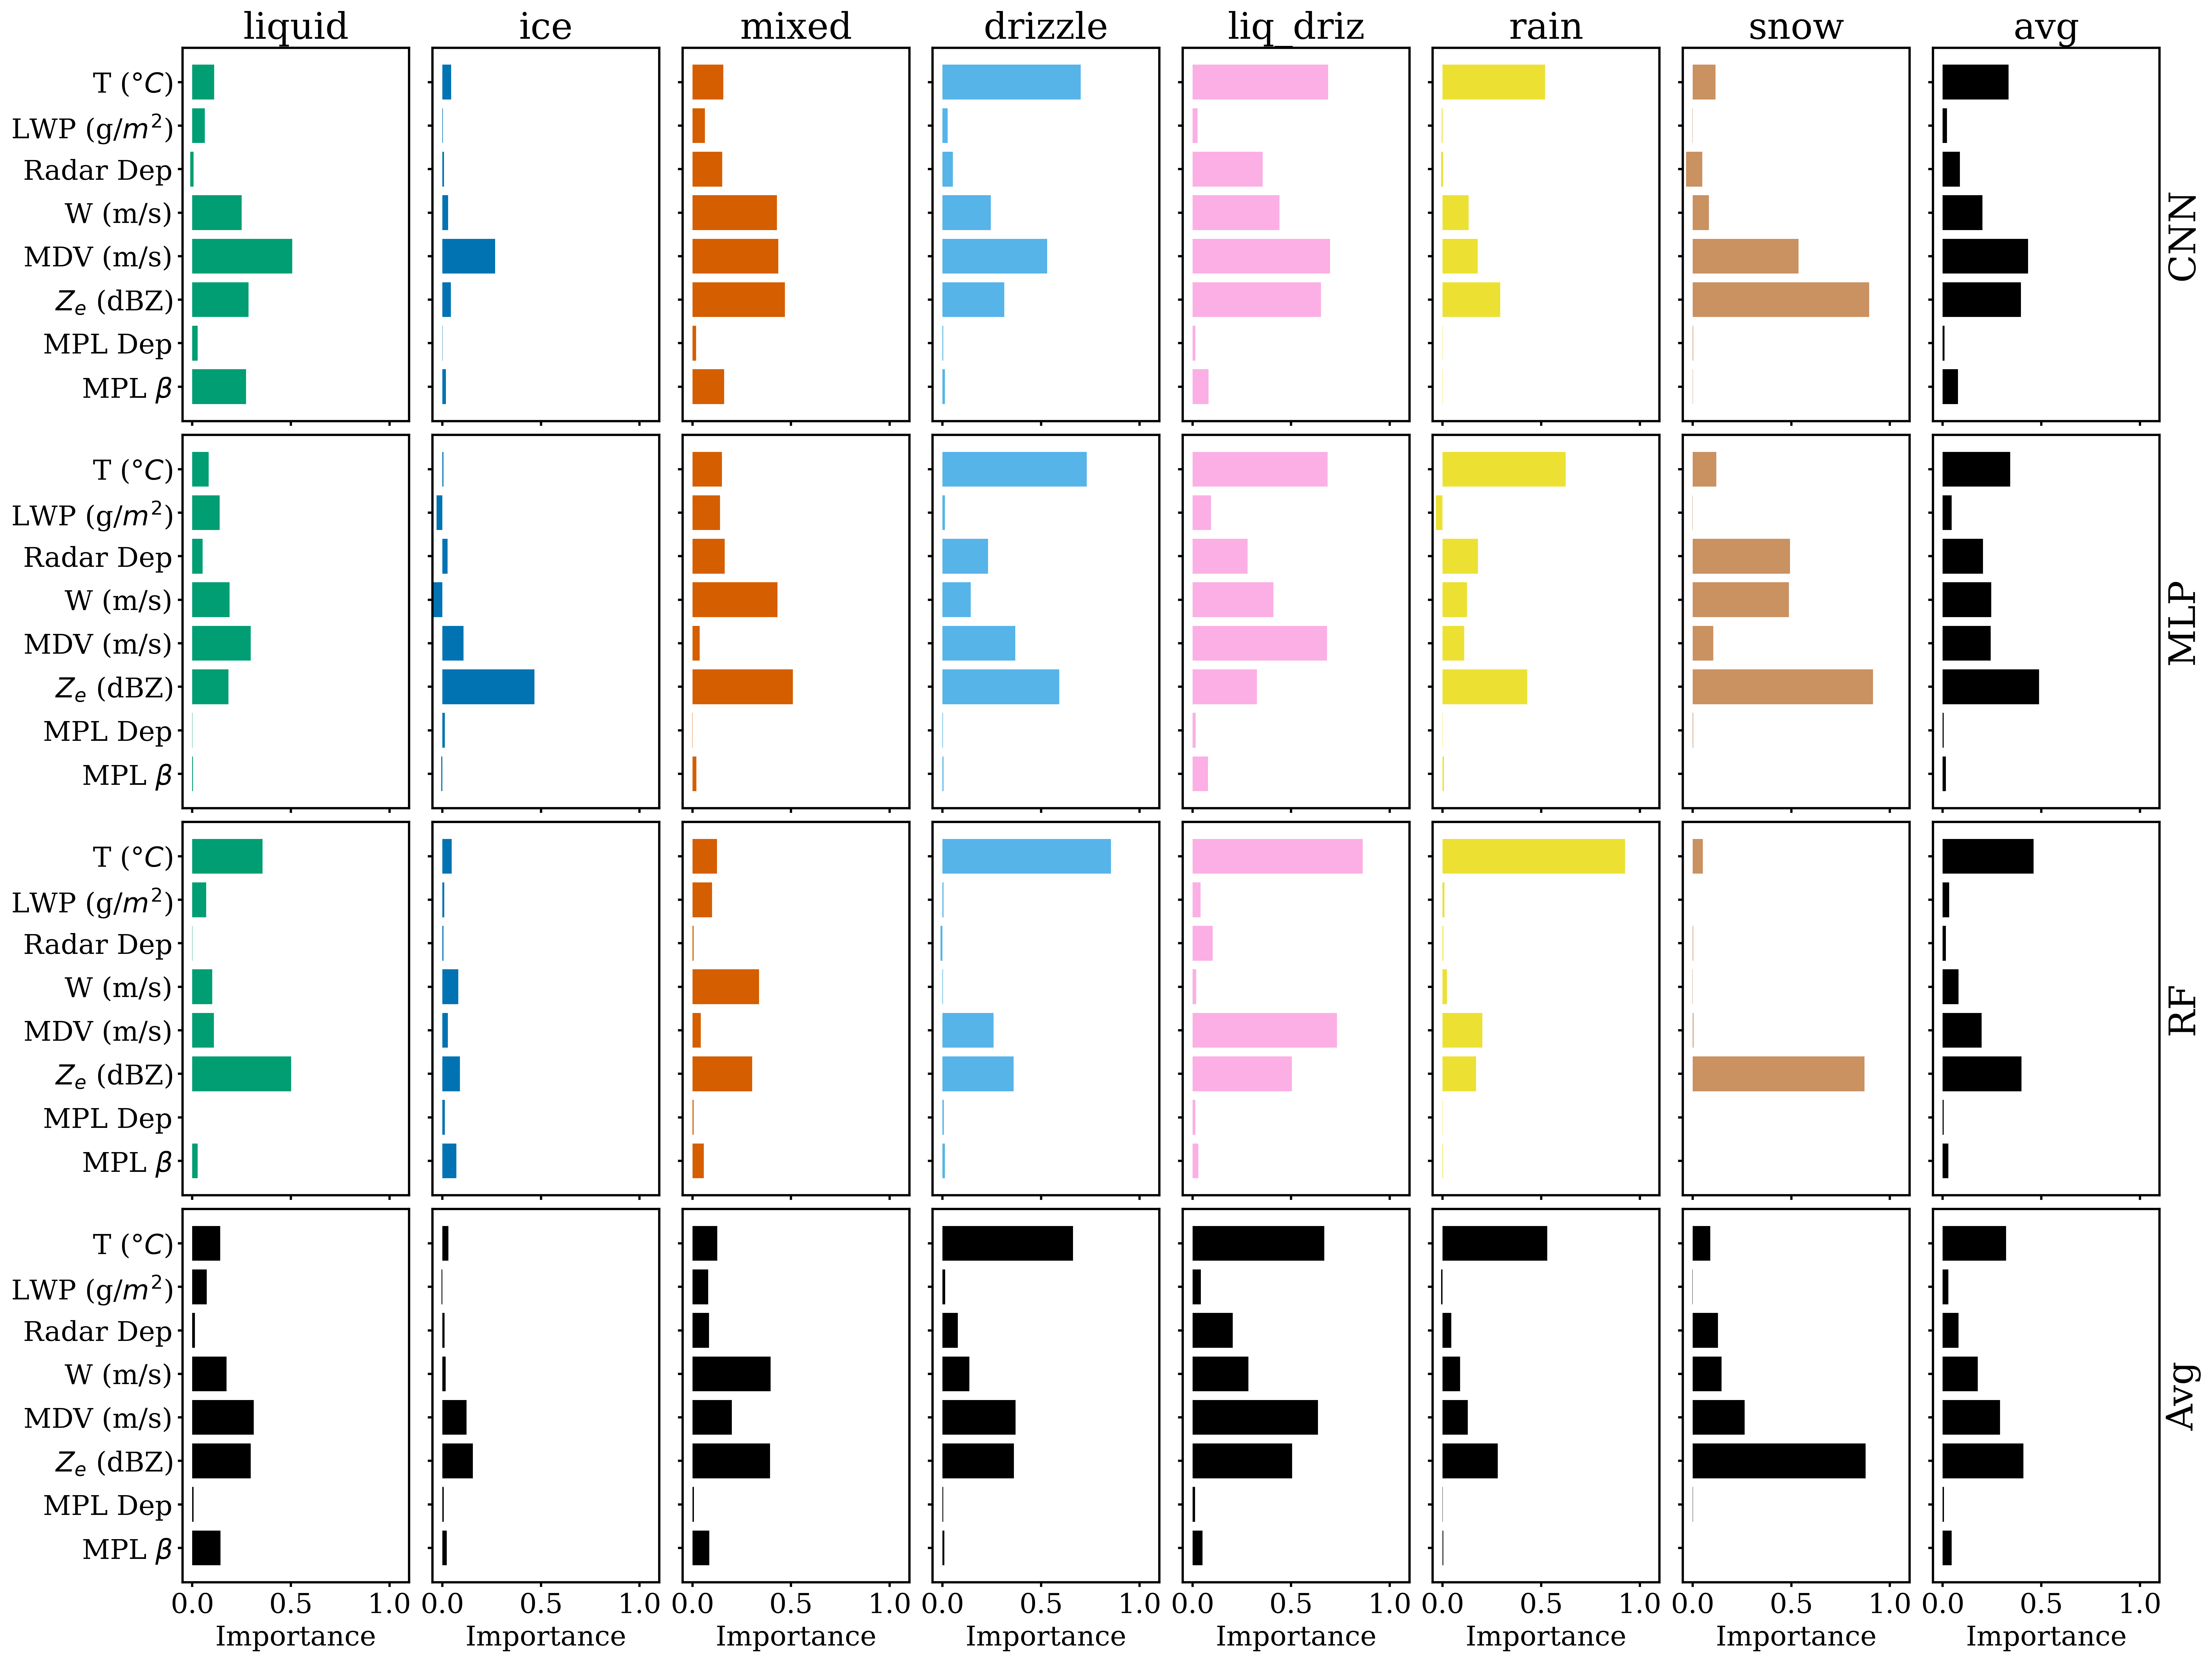

In [15]:



fig, axs = plt.subplots(len(models), len(phases), figsize=(20, 15), sharey=True, sharex=True, layout="constrained")
for i, model in enumerate(models):
    for j, phase in enumerate(phases):
        ax = axs[i, j]
        data_to_plot = imp_df[(imp_df['model'] == model) & (imp_df['phase'] == phase)]
        if not data_to_plot.empty:
            ax.barh(data_to_plot['feature'], data_to_plot['importance'], color=cmap[phase] if model != "avg" else "black")
            ax.set_xlim([-0.05, 1.1])  # Adjust according to your data range
            ax.xaxis.set_ticks([0.0, 0.5, 1.0])
            ax.tick_params(axis='both', which='major', labelsize=18)

# Set Model Labels
j = len(phases) - 1
for i, model in enumerate(models.values()):
    ax = axs[i, j]
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(model, fontsize=24)

# Set Phase Labels
i = 0
for j, phase in enumerate(phases):
    ax = axs[i, j]
    ax.set_title(phase, fontsize=24)

# Set Importance X Label
i = len(models) - 1
for j in range(len(phases)):
    ax = axs[i, j]
    ax.set_xlabel("Importance", fontsize=18)

# plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.savefig("figures/all_importances.png")
plt.show()

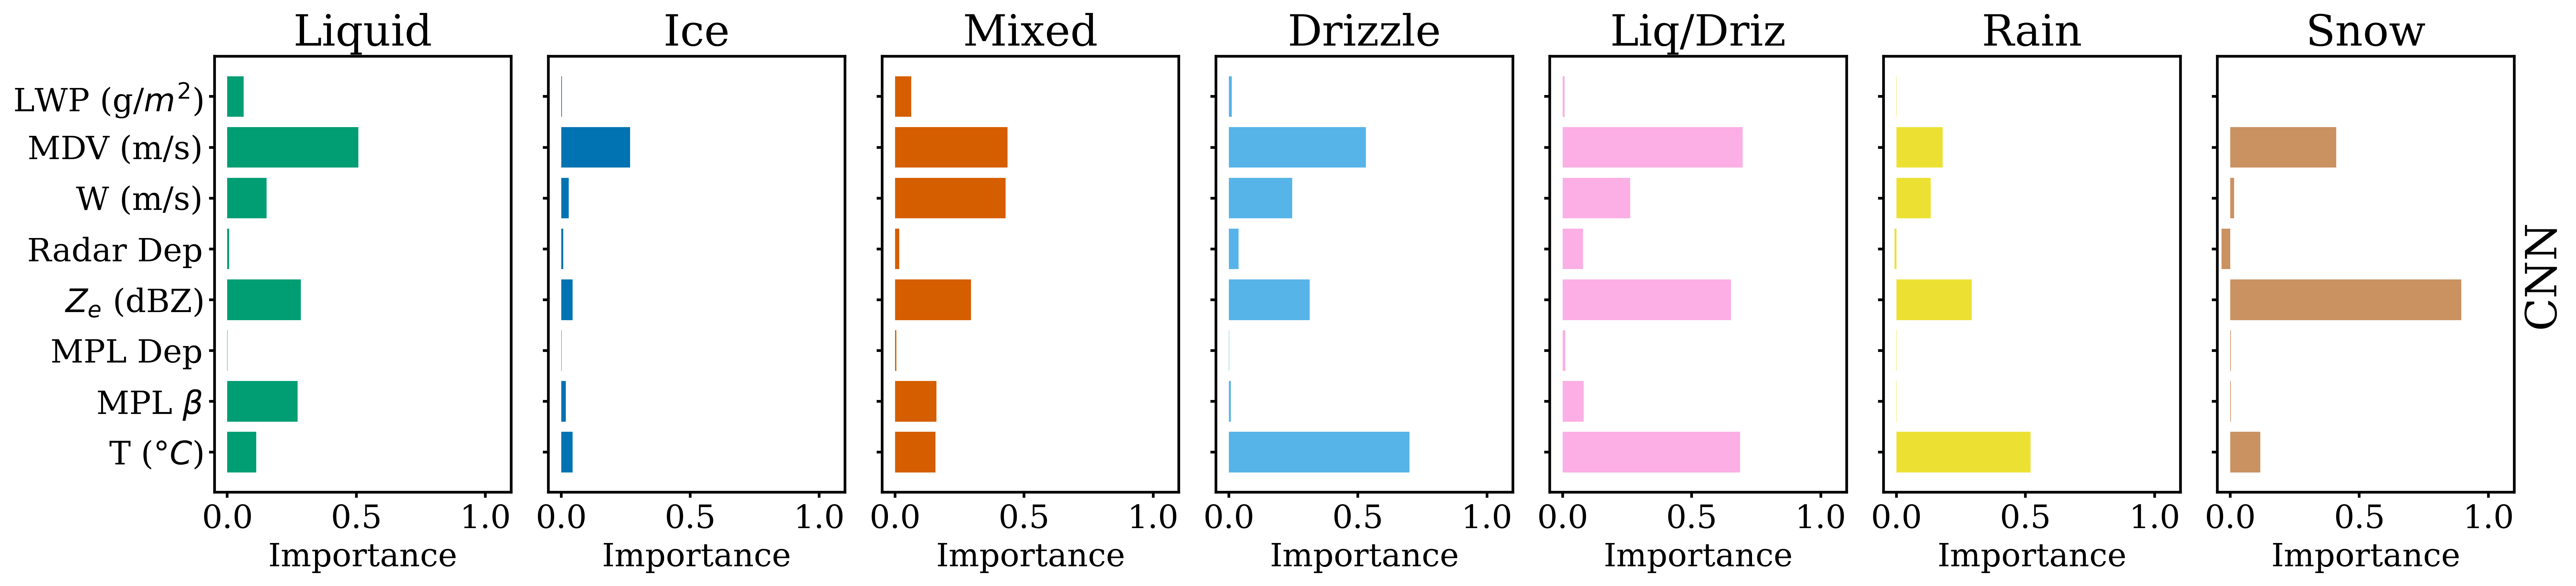

In [ ]:
phases = {
    "liquid": "Liquid", 
    "ice": "Ice", 
    "mixed": "Mixed", 
    "drizzle": "Drizzle", 
    "liq_driz": "Liq/Driz", 
    "rain": "Rain", 
    "snow": "Snow",
    # "avg": "Avg",
}
model, model_label = "cnnB", "CNN"


df = p_i_df.reset_index()

with plt.style.context("style.mplstyle"):
    fig, axs = plt.subplots(1, len(phases), figsize=(20, 5), sharey=True)
    for j, phase in enumerate(phases):
        ax = axs[j]
        data_to_plot = df[(df['model'] == model) & (df['phase'] == phase)]
        if not data_to_plot.empty:
            ax.barh(data_to_plot['feature'], data_to_plot['importance'], color=cmap[phase] if model != "avg" else "black")
            ax.set_xlim([-0.05, 1.1])
            ax.xaxis.set_ticks([0.0, 0.5, 1.0])
            ax.tick_params(axis='both', which='major', labelsize=18)

    # Set Model Labels
    ax = axs[-1]
    ax.yaxis.set_label_position("right")
    ax.set_ylabel(model_label, fontsize=24)

    for j, phase in enumerate(phases.values()):
        ax = axs[j]
        ax.set_title(phase, fontsize=24)
        ax.set_xlabel("Importance", fontsize=18)


    # fig.suptitle('Feature Importance by Model and Phase', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    fig.savefig("figures/cnn_importances_v1.png")
    plt.show()

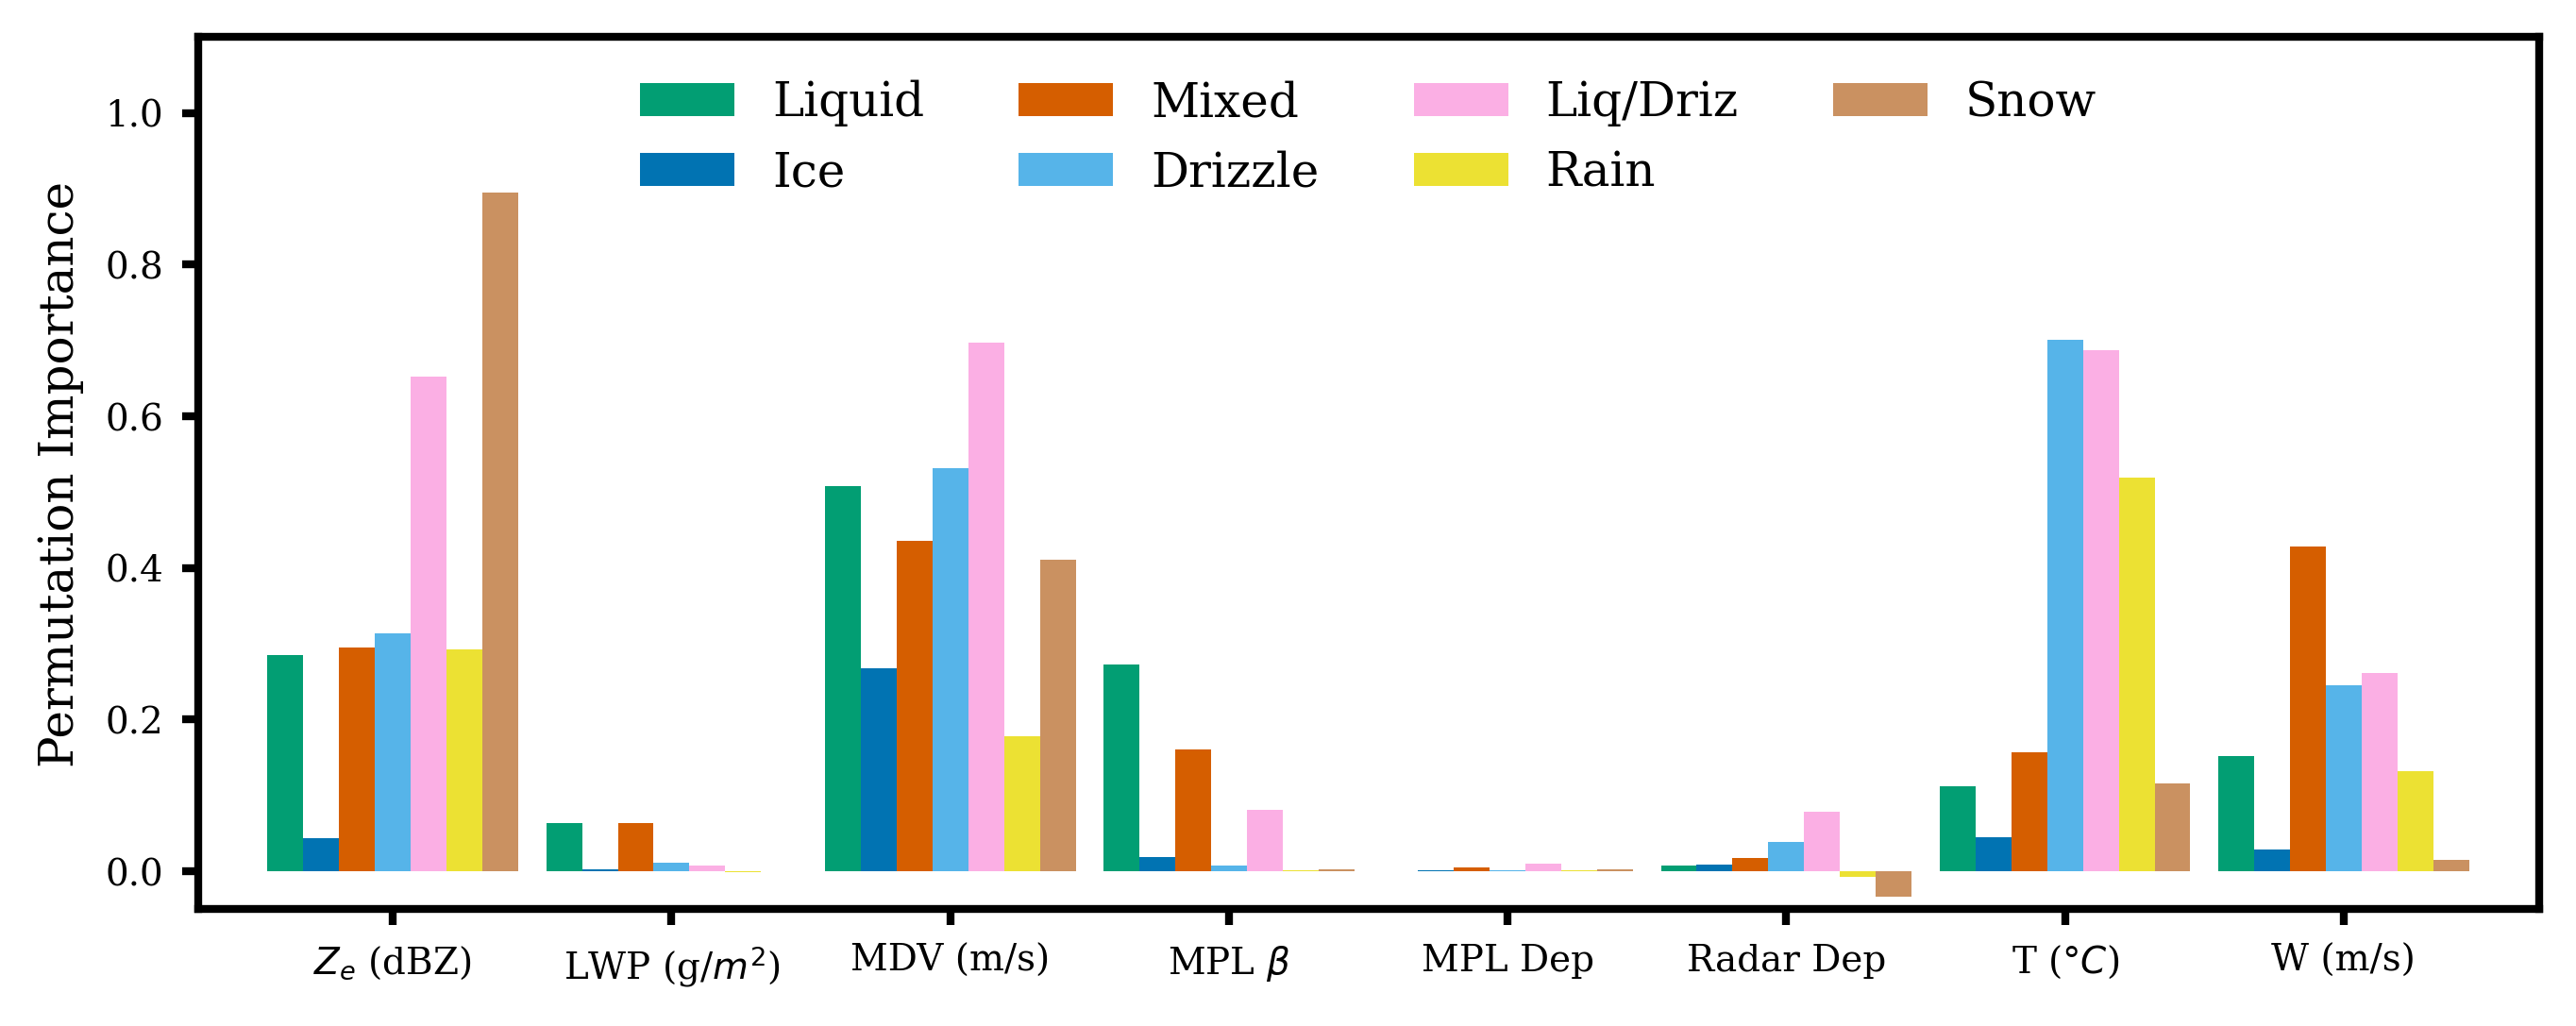

In [7]:
# This is the plot we wind up using in the paper text
phases = {
    "liquid": "Liquid", 
    "ice": "Ice", 
    "mixed": "Mixed", 
    "drizzle": "Drizzle", 
    "liq_driz": "Liq/Driz", 
    "rain": "Rain", 
    "snow": "Snow",
    # "avg": "Avg",
}
renamed_cmap = {phases[p]: c for p, c in cmap.items() if p in phases}

model = "cnnB"
with plt.style.context("style.mplstyle"):
    fig, ax = plt.subplots(figsize=(8, 3))
    data = df[(df["model"] == model) & (df["phase"] != "avg")].pivot(index="feature",columns="phase", values="importance")
    data = data[list(phases)].rename(columns=phases)
    data.plot.bar(ax=ax, width=0.9, color=renamed_cmap, legend=None)

    ax.set_ylim(min(-0.05, data.min().min() - 0.01), 1.1)

    ax.set_xlabel("")
    ax.set_ylabel("Permutation Importance")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    plt.legend(
        loc="upper center",
        # bbox_to_anchor=(0.5, -0.15),
        ncol=4
    )
    fig.savefig(f"figures/{model}_importances.png")
    plt.show()

In [26]:
print(model)
# df[(df["model"] == model) & (df["phase"] != "avg")]
df["model"].unique()

cnnB


array(['cnnA', 'cnnB', 'mlp', 'rf', 'avg'], dtype=object)

In [27]:
df

,feature,acc,importance,model
phase,,,,
liquid,T ($\degree C$),0.634770,0.016828,cnnA
ice,T ($\degree C$),0.965612,0.025751,cnnA
mixed,T ($\degree C$),0.558346,0.074858,cnnA
drizzle,T ($\degree C$),0.180685,0.363496,cnnA
liq_driz,T ($\degree C$),0.224538,0.435818,cnnA
...,...,...,...,...
snow,MPL $\beta$,0.942381,0.000719,avg
snow,MPL Dep,0.941335,0.001765,avg
snow,Radar Dep,0.815026,0.128074,avg


In [30]:
df = df.reset_index()

In [31]:
df[(df["model"] == model) & (df["phase"] != "avg")]#.pivot(index="feature",columns="phase", values="importance")

,phase,feature,acc,importance,model
64,liquid,T ($\degree C$),0.769947,0.111658,cnnB
65,ice,T ($\degree C$),0.940107,0.044474,cnnB
66,mixed,T ($\degree C$),0.680248,0.156318,cnnB
67,drizzle,T ($\degree C$),0.125119,0.700422,cnnB
68,liq_driz,T ($\degree C$),0.134596,0.687322,cnnB
69,rain,T ($\degree C$),0.459007,0.519130,cnnB
70,snow,T ($\degree C$),0.821082,0.116228,cnnB
72,liquid,MPL $\beta$,0.609254,0.272351,cnnB
73,ice,MPL $\beta$,0.966042,0.018538,cnnB
74,mixed,MPL $\beta$,0.676002,0.160564,cnnB


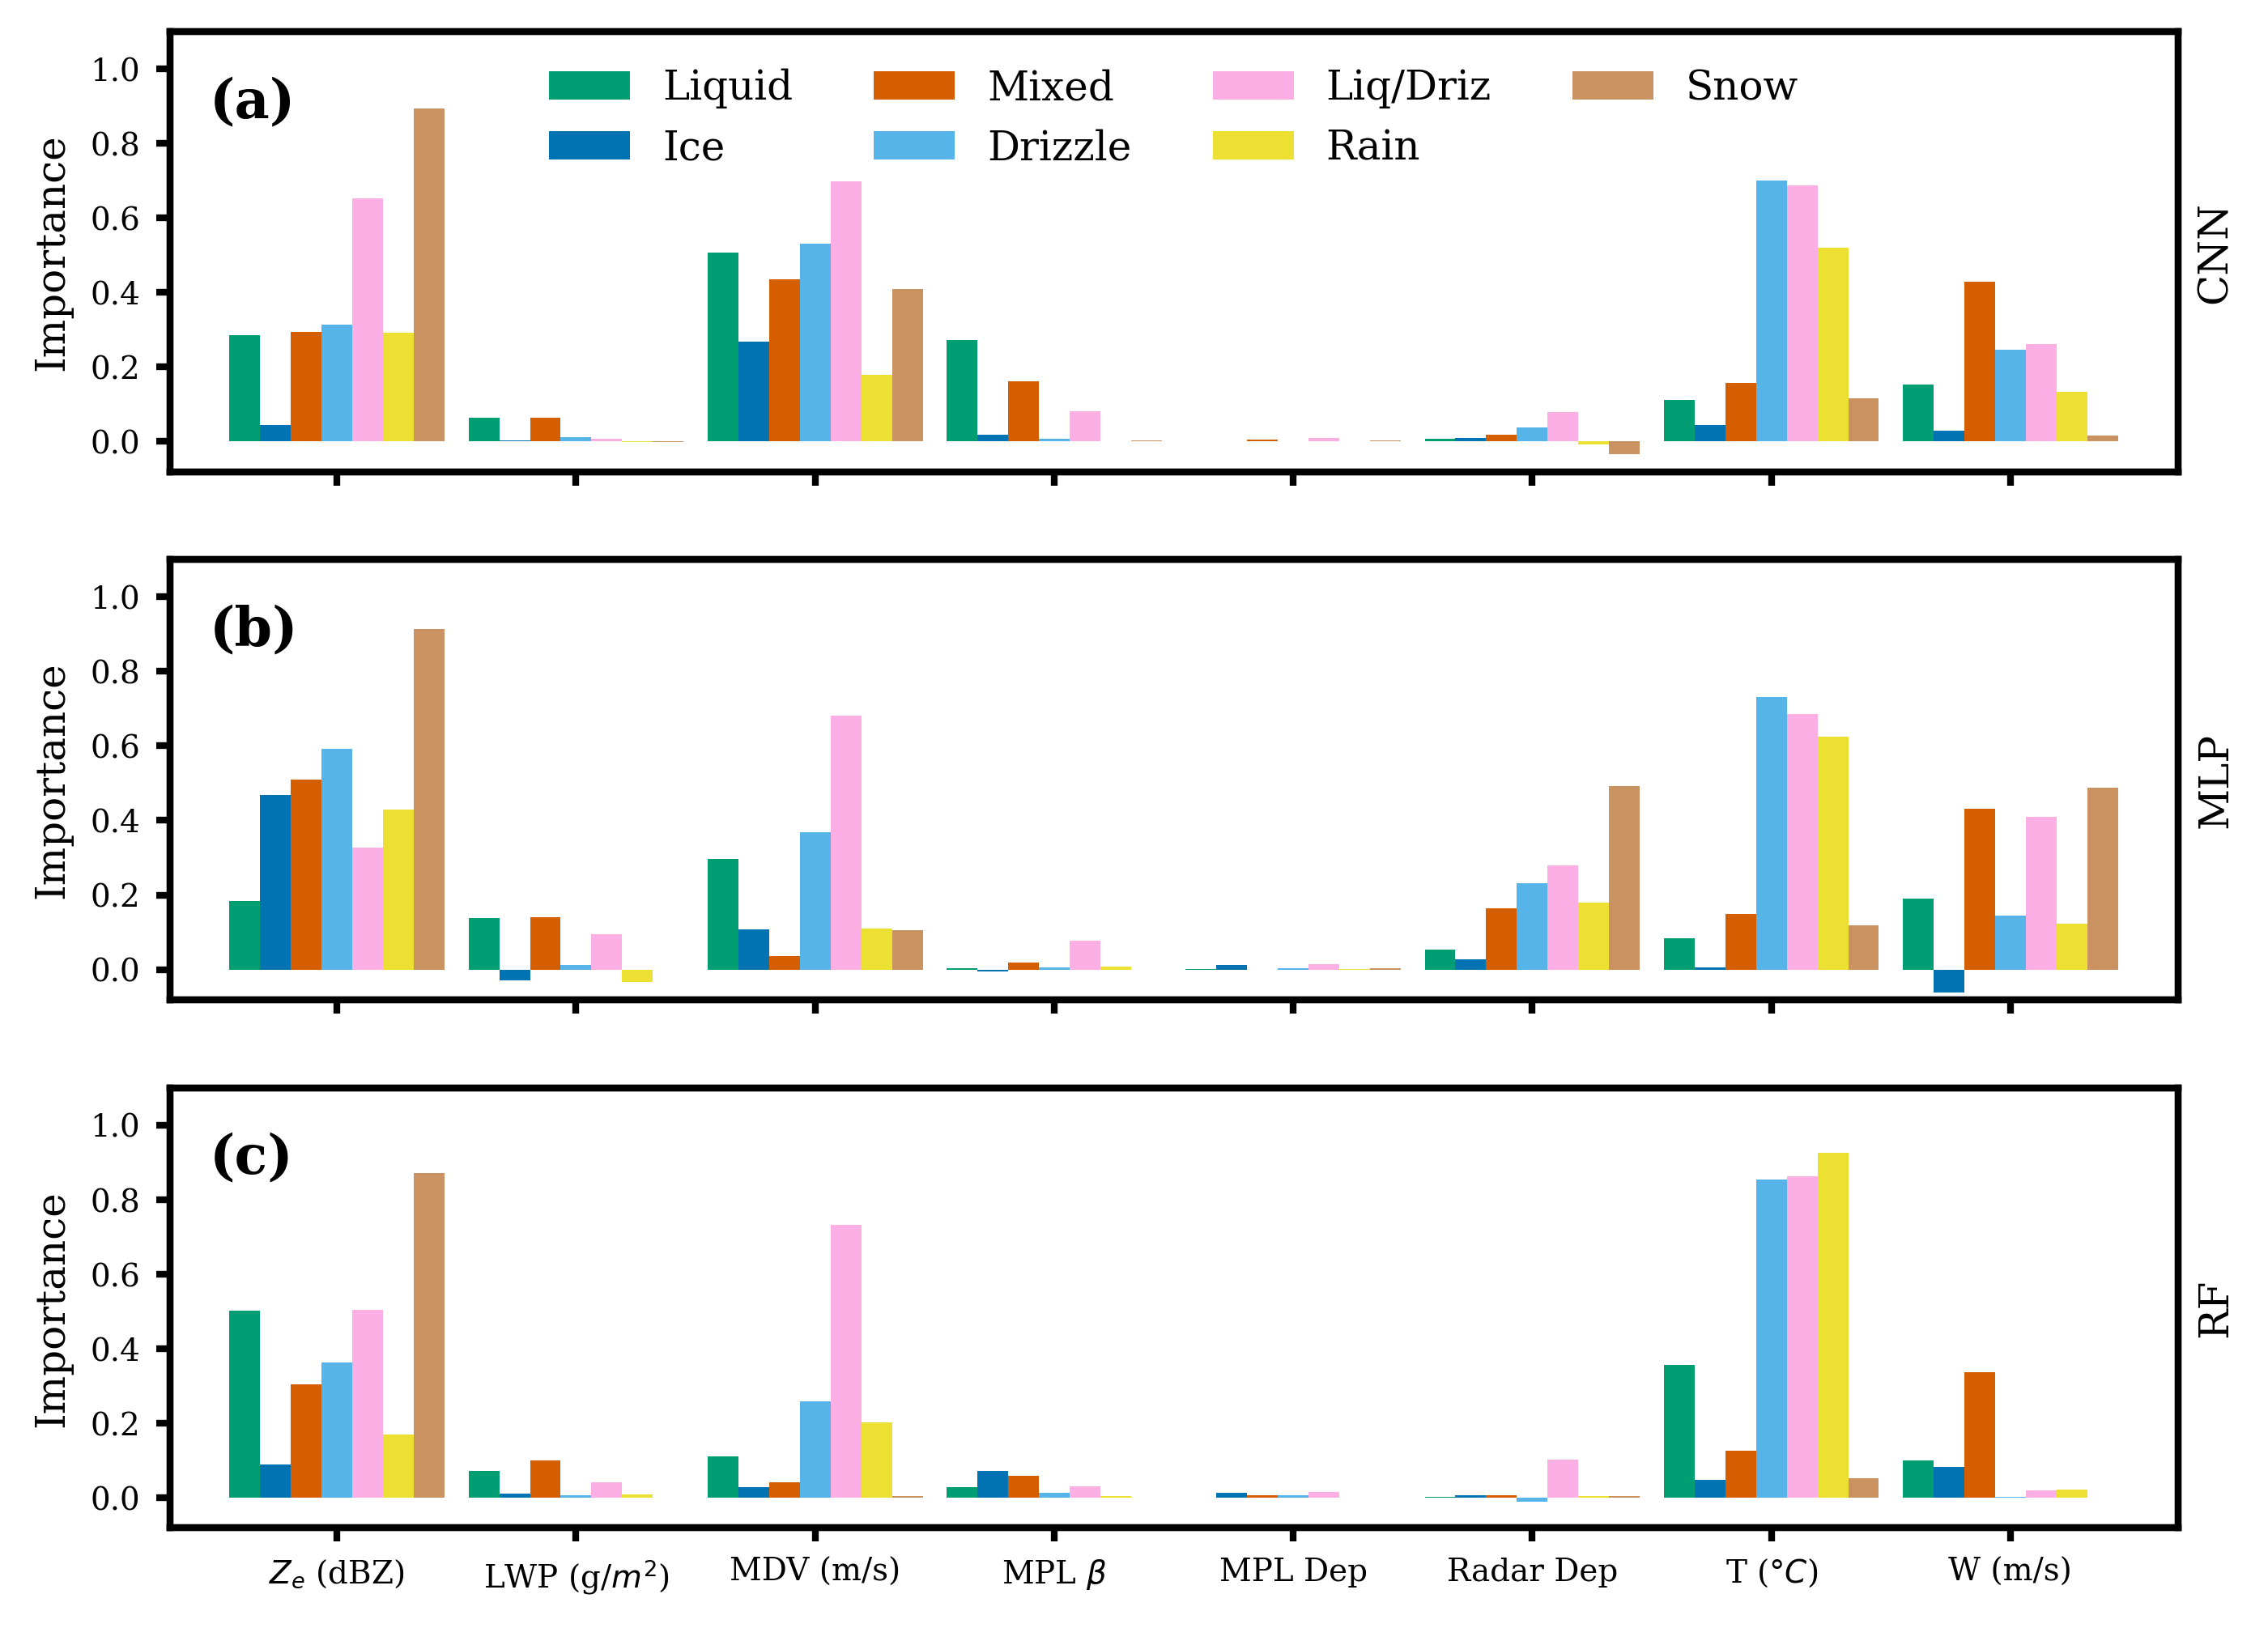

In [17]:
data

phase,Liquid,Ice,Mixed,Drizzle,Liq/Driz,Rain,Snow
feature,,,,,,,
$Z_e$ (dBZ),0.183476,0.467657,0.509488,0.591776,0.326764,0.429183,0.914162
LWP (g/$m^2$),0.138818,-0.029256,0.140043,0.012572,0.094218,-0.033406,-0.001937
MDV (m/s),0.296718,0.106758,0.036968,0.368561,0.682057,0.109860,0.105365
MPL $\beta$,0.004061,-0.005716,0.019415,0.005830,0.078182,0.006668,-0.000573
MPL Dep,0.000722,0.012607,-0.000857,0.003158,0.015198,0.001413,0.002517
Radar Dep,0.052621,0.026295,0.163533,0.231210,0.279456,0.179961,0.493346
T ($\degree C$),0.082779,0.005915,0.150021,0.731967,0.685387,0.624811,0.119413
W (m/s),0.189376,-0.061316,0.431190,0.143958,0.409928,0.123911,0.488356
